In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [3]:
!ls

sample_data  spam.csv


In [4]:
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

In [5]:
df = pd.read_csv("spam.csv", encoding= "ISO-8859-1")

In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df = df.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis =1 )

In [8]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.columns = ["label","data"]

In [10]:
df["n_label"] = df["label"].map({"ham":0,"spam":1})

In [11]:
df.head()

,label,data,n_label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [12]:
df_train, df_test = train_test_split(df,test_size=0.33)

In [13]:
df_train.shape,df_test.shape

((3733, 3), (1839, 3))

In [14]:
df_train.head()

,label,data,n_label
3164,ham,Cheers for the card ... Is it that time of yea...,0
4762,ham,Prepare to be pleasured :),0
883,ham,Dude we should go sup again,0
1203,ham,Thanks for understanding. I've been trying to ...,0
2461,ham,Anything lar...,0


In [15]:

#tokenization


word2idx = {"pad":0}


count = 1
for i, row in df_train.iterrows():


  split_data = row["data"].lower().split()

  for w in split_data:
    if w not in word2idx:

      word2idx[w]= count
      count+=1



In [16]:
doc_list = []
for i,row in df_train.iterrows():
  a = [word2idx[token] for token in row["data"].lower().split()]
  doc_list.append(a)


In [17]:
len(word2idx)

10703

In [18]:
doc_list_test = []
for i,row in df_test.iterrows():
  a = [word2idx[token] for token in row["data"].lower().split() if token in word2idx]
  doc_list_test.append(a)

In [19]:
#Data generation

def datagen(X,y):

  batch_size = 32
  n_batches = int(np.ceil(len(y)/batch_size))

  for i in range(n_batches):
    end = min((i+1)*batch_size,len(y))
    X_batch = X[i*batch_size:end]
    Y_batch = y[i*batch_size:end]

    max_len = np.max([len(i) for i in X_batch])

    for i in range(len(X_batch)):
      X_batch[i] = [0]*(max_len - len(X_batch[i])) + X_batch[i]

    X_batch = torch.from_numpy(np.array(X_batch)).long()
    Y_batch = torch.from_numpy(np.array(Y_batch)).long()

    yield X_batch, Y_batch

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [21]:
#Model

class CNN(nn.Module):
  def __init__(self, n_vocab, embed_dim,n_outputs):
    super(CNN,self).__init__()

    self.D = embed_dim
    self.V = n_vocab
    self.K = n_outputs

    self.embed = nn.Embedding(self.V,self.D)


    self.cnn = nn.Sequential(nn.Conv1d(self.D,32,3,padding=1),
                             nn.ReLU(),
                             nn.MaxPool1d(2),
                             nn.Conv1d(32,64,3,padding=1),
                             nn.ReLU(),
                             nn.MaxPool1d(2),
                             nn.Conv1d(64,128,3,padding=1),
                             nn.ReLU(),
                             nn.MaxPool1d(2)

                             )



    self.fc = nn.Linear(128,self.K)

  def forward(self,x):



    out = self.embed(x)
    out = out.permute(0,2,1)
    out = self.cnn(out)


    out = out.permute(0,2,1)
    out,_ = torch.max(out,1)

    out = self.fc(out)

    return out

In [22]:
model = CNN(len(word2idx),20,1)
model.to(device)

CNN(
  (embed): Embedding(10703, 20)
  (cnn): Sequential(
    (0): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [23]:
#optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [24]:
traingen = lambda: datagen(doc_list, df_train.n_label)
testgen = lambda: datagen(doc_list_test, df_test.n_label)

In [25]:
#training

epochs = 8
train_loss_1 = np.zeros(epochs)
test_loss_1 = np.zeros(epochs)

for i in range(epochs):


  t_0 = datetime.now()
  loss_t = []
  for inputs,targets in traingen():

    targets = targets.view(-1,1).float()

    inputs,targets = inputs.to(device), targets.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss_train = criterion(outputs,targets)

    loss_train.backward()

    optimizer.step()

    loss_t.append(loss_train.item())

  train_loss = np.mean(loss_t)
  train_loss_1[i] = train_loss

  loss_test1 = []

  for inputs,targets in testgen():
    targets = targets.view(-1,1).float()

    inputs,targets = inputs.to(device), targets.to(device)

    outputs = model(inputs)

    loss_test = criterion(outputs,targets)



    loss_test1.append(loss_test.item())

  test_loss = np.mean(loss_test1)
  test_loss_1[i] = test_loss

  dt = datetime.now() - t_0
  print(f"epoch -- {i+1}/{epochs}, training loss -- {train_loss}, test loss -- {test_loss}, Duration -- {dt}")











epoch -- 1/8, training loss -- 0.3915544485943949, test loss -- 0.35517500674930114, Duration -- 0:00:04.201354
epoch -- 2/8, training loss -- 0.24824517000562105, test loss -- 0.18347700736645994, Duration -- 0:00:01.111560
epoch -- 3/8, training loss -- 0.14146041986333507, test loss -- 0.14765940458867058, Duration -- 0:00:01.284392
epoch -- 4/8, training loss -- 0.09505071831691979, test loss -- 0.13661852527152876, Duration -- 0:00:00.825794
epoch -- 5/8, training loss -- 0.06623314643023998, test loss -- 0.13702488542887672, Duration -- 0:00:00.723381
epoch -- 6/8, training loss -- 0.053909695297320426, test loss -- 0.16094531683283375, Duration -- 0:00:00.860241
epoch -- 7/8, training loss -- 0.041472030398595094, test loss -- 0.14369443966204237, Duration -- 0:00:00.776746
epoch -- 8/8, training loss -- 0.030404099486131445, test loss -- 0.1337918240480639, Duration -- 0:00:01.038763


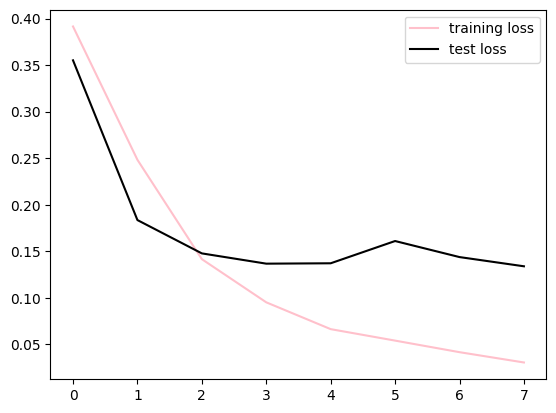

In [26]:
plt.plot(train_loss_1,label = "training loss",c = "pink")
plt.plot(test_loss_1,label = "test loss", c = "black")
plt.legend()
plt.show()

In [27]:
n_correct = 0
n_total = 0

for inputs, targets in traingen():

  targets = targets.view(-1,1).float()

  inputs,targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  predictions = (outputs>0)

  n_correct += (predictions == targets).sum().item()

  n_total += len(targets)

train_acc = n_correct/n_total

n_correct_1 = 0
n_total_1 = 0


for inputs, targets in testgen():

  targets = targets.view(-1,1).float()

  inputs,targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  predictions = (outputs>0)

  n_correct_1 += (predictions == targets).sum().item()

  n_total_1 += len(targets)

test_acc = n_correct_1/n_total_1


print(f"train acc -- {train_acc}, test acc -- {test_acc}" )


train acc -- 0.99732118939191, test acc -- 0.9679173463839043
